In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)


In [24]:
''' reading data'''
df = pd.read_csv('amazon_alexa.tsv', delimiter='\t')

In [25]:
''' displayind first 5 rows'''
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [26]:
''' cheching null values'''
df.isnull().sum()


rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [27]:
''' checking info of data '''
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Name: count, dtype: int64


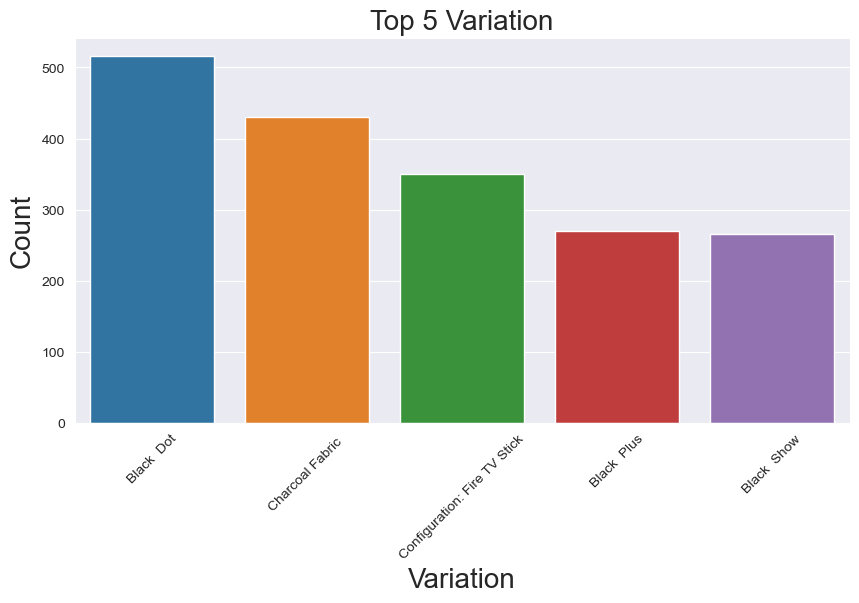

In [28]:
''' value counts of variation '''
variation_label = df['variation'].value_counts()[:5]
print(variation_label)

''' plotting top 5 variation '''
plt.figure(figsize=(10, 5))
sns.barplot(x=variation_label.index, y=variation_label.values);
plt.xlabel('Variation', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Top 5 Variation', fontsize=20);
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.show()

In [29]:
''' shape of data '''
df.shape

(3150, 5)

In [31]:
'''Assuming df is your DataFrame''' 
'''First, check for NaN values in the 'verified_reviews' column''' 
print(df['verified_reviews'].isnull().sum())

'''Drop rows with NaN values in the 'verified_reviews' column'''
df = df.dropna(subset=['verified_reviews'])

'''Now, apply the len() function to calculate the length of each review'''
df['len'] = df['verified_reviews'].map(len)

''' Print the 'len' column to verify the results''' 
print(df['len'])


1
0        13
1         9
2       195
3       172
4         5
       ... 
3145     50
3146    135
3147    441
3148    380
3149      4
Name: len, Length: 3149, dtype: int64


In [32]:
''' displaying data based on len '''
df.groupby('len').describe().sample(10)

rating                                                feedback            \
     count      mean       std  min   25%  50%   75%  max    count      mean   
len                                                                            
522    2.0  4.000000  0.000000  4.0  4.00  4.0  4.00  4.0      2.0  1.000000   
626    1.0  3.000000       NaN  3.0  3.00  3.0  3.00  3.0      1.0  1.000000   
265    1.0  5.000000       NaN  5.0  5.00  5.0  5.00  5.0      1.0  1.000000   
211    6.0  3.833333  1.329160  2.0  3.00  4.0  5.00  5.0      6.0  0.833333   
100    8.0  4.875000  0.353553  4.0  5.00  5.0  5.00  5.0      8.0  1.000000   
289    2.0  2.500000  2.121320  1.0  1.75  2.5  3.25  4.0      2.0  0.500000   
45    14.0  4.857143  0.534522  3.0  5.00  5.0  5.00  5.0     14.0  1.000000   
290    3.0  4.666667  0.577350  4.0  4.50  5.0  5.00  5.0      3.0  1.000000   
251    2.0  3.000000  0.000000  3.0  3.00  3.0  3.00  3.0      2.0  1.000000   
248    2.0  5.000000  0.000000  5.0  5.00  5.0  5.00  5.0      2.0  1.000000   

                                          
          std  min   25%  50%   75%  max  
len                                       
522  0.000000  1.0  1.00  1.0  1.00  1.0  
626       NaN  1.0  1.00  1.0  1.00  1.0  
265       NaN  1.0  1.00  1.0  1.00  1.0  
211  0.408248  0.0  1.00  1.0  1.00  1.0  
100  0.000000  1.0  1.00  1.0  1.00  1.0  
289  0.707107  0.0  0.25  0.5  0.75  1.0  
45   0.000000  1.0  1.00  1.0  1.00  1.0  
290  0.000000  1.0  1.00  1.0  1.00  1.0  
251  0.000000  1.0  1.00  1.0  1.00  1.0  
248  0.000000  1.0  1.00  1.0  1.00  1.0

In [33]:
''' displaying data based on ratings '''
df.groupby('rating').describe()

feedback                                        len              \
          count mean  std  min  25%  50%  75%  max   count        mean   
rating                                                                   
1         161.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   161.0  195.000000   
2          95.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    95.0  251.768421   
3         152.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   152.0  207.296053   
4         455.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   455.0  178.520879   
5        2286.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  2286.0  108.444007   

                                                     
               std  min   25%    50%    75%     max  
rating                                               
1       212.371226  1.0  36.0  120.0  284.0  1124.0  
2       269.830619  1.0  79.0  163.0  311.5  1686.0  
3       272.194706  1.0  54.0  130.0  284.0  1954.0  
4       215.927849  1.0  34.0   99.0  241.0  1360.0  
5       152.116387  1.0  26.0   64.0  135.0  2851.0

In [34]:
''' displaying data based on feedback '''
df.groupby('feedback').describe()

rating                                                  len  \
           count      mean       std  min  25%  50%  75%  max   count   
feedback                                                                
0          256.0  1.371094  0.484044  1.0  1.0  1.0  2.0  2.0   256.0   
1         2893.0  4.737643  0.546544  3.0  5.0  5.0  5.0  5.0  2893.0   

                                                                    
                mean         std  min   25%    50%     75%     max  
feedback                                                            
0         216.066406  236.417642  1.0  53.0  138.0  291.75  1686.0  
1         124.659177  174.624491  1.0  29.0   69.0  154.00  2851.0

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


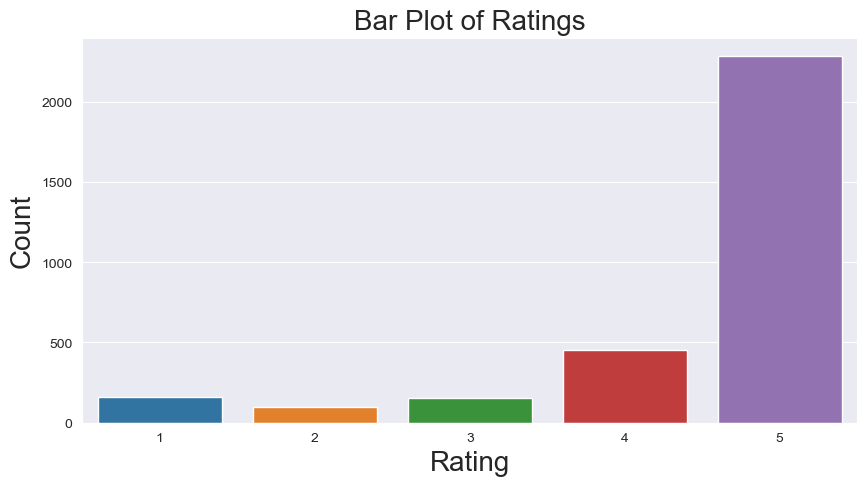

In [35]:
''' visualization '''

''' value counts of rating '''
rating_label = df['rating'].value_counts()
print(rating_label)

''' barplot '''
plt.figure(figsize=(10, 5))
sns.barplot(x=rating_label.index, y=rating_label);
plt.xlabel('Rating', fontsize=20)
plt.ylabel('Count', fontsize=20);
plt.title('Bar Plot of Ratings', fontsize=20);

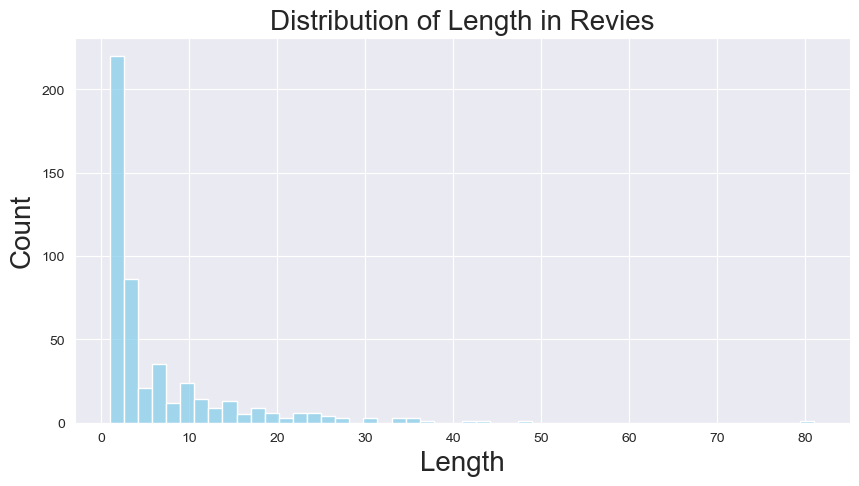

In [36]:
''' histogram plot of len of reviews '''
len_label = df['len'].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(len_label, bins=50, color='skyblue');
plt.xlabel('Length', fontsize=20)
plt.ylabel('Count', fontsize=20);
plt.title('Distribution of Length in Revies', fontsize=20);

In [37]:
''' Let's check some of the reviews according to their lengths '''
df[df.len == 1]['verified_reviews'].iloc[0]

'😍'

In [38]:
df[df['len'] == 150]['verified_reviews'].iloc[0]

"Got this on Amazon prime with the ring pro. Work really great. Being the lazy guy I am I don't need to go see who at my door anymore while I'm gaming."

In [39]:
df[df['len'] == 50]['verified_reviews'].iloc[0]

'Yet another Exho for our home and love them all!!!'

In [40]:
df[df['len'] == 25]['verified_reviews'].iloc[0]

'I love it, wife hates it.'

Text(0, 0.5, 'length')

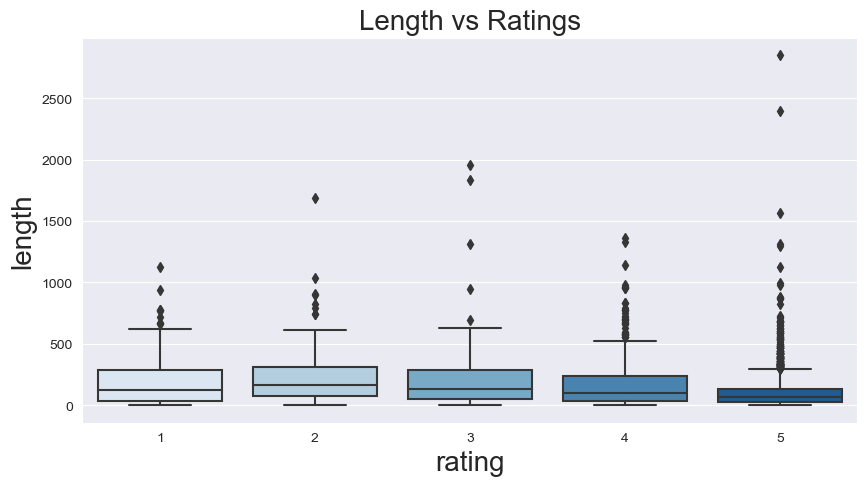

In [41]:
''' box plot '''
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['rating'], y=df['len'], palette = 'Blues')
plt.title("Length vs Ratings", fontsize=20)
plt.xlabel('rating', fontsize=20)
plt.ylabel('length', fontsize=20)

Text(0, 0.5, 'rating')

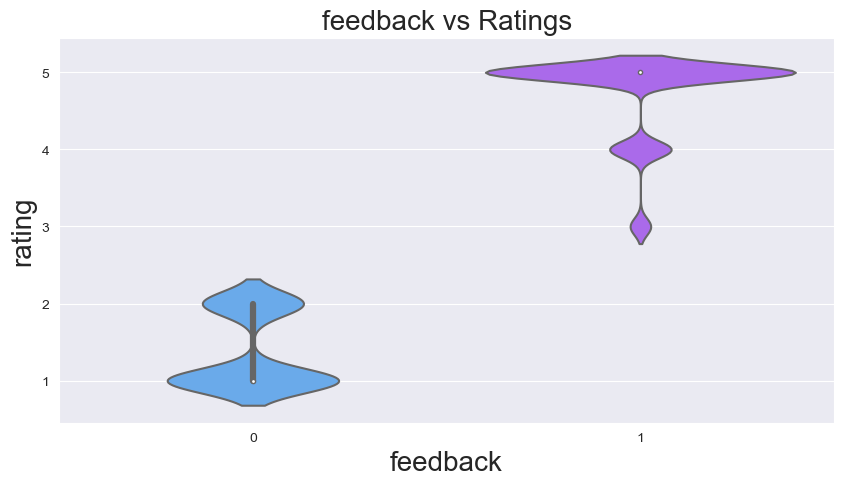

In [42]:
''' violin plot '''
plt.figure(figsize=(10, 5))
sns.violinplot(x=df['feedback'], y=df['rating'], palette = 'cool')
plt.title("feedback vs Ratings", fontsize=20)
plt.xlabel('feedback', fontsize=20)
plt.ylabel('rating', fontsize=20)

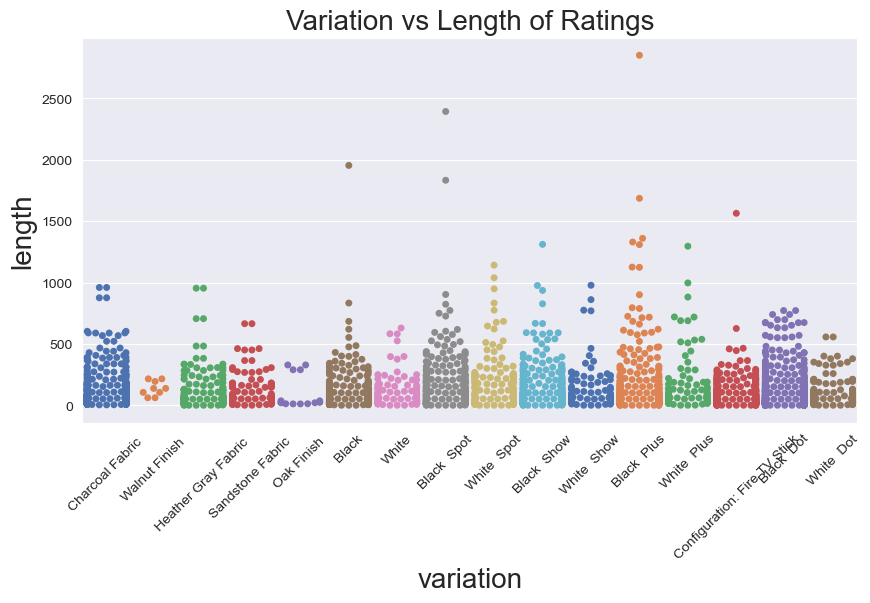

In [65]:
''' swarmplot '''
plt.figure(figsize=(10, 5))
sns.swarmplot(x=df['variation'], y=df['len'], palette = 'deep')
plt.title("Variation vs Length of Ratings", fontsize=20)
plt.xlabel('variation', fontsize=20)
plt.ylabel('length', fontsize=20);
plt.xticks(rotation=45);
plt.show()

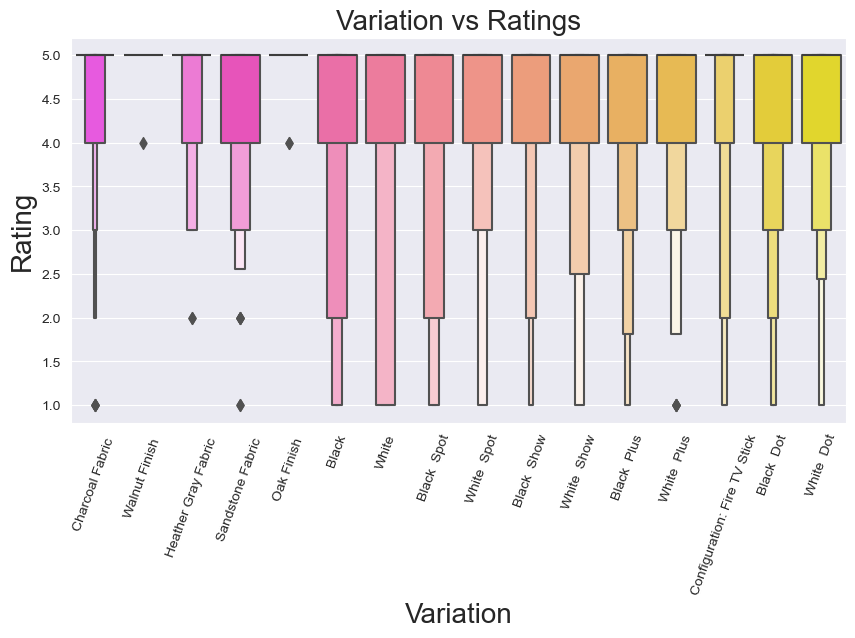

In [66]:
''' bivariate analysis'''
plt.figure(figsize=(10, 5))
sns.boxenplot(x=df['variation'], y=df['rating'], palette = 'spring')
plt.title("Variation vs Ratings", fontsize=20)
plt.xticks(rotation=70);
plt.xlabel('Variation', fontsize=20)
plt.ylabel('Rating', fontsize=20);
plt.show()

In [90]:
''' preprocesing of text '''

''' CountVectorrizer '''
count_vector = CountVectorizer(stop_words='english')

ws = count_vector.fit_transform(df.verified_reviews)
s_w = ws.sum(axis=0)
w_f = [(w, s_w[0, idx]) for w, idx in count_vector.vocabulary_.items()]
w_f = sorted(w_f, key= lambda x: x[1], reverse = True)
             

''' creating dataframe '''
freq = pd.DataFrame(w_f, columns=['word', 'freq'])

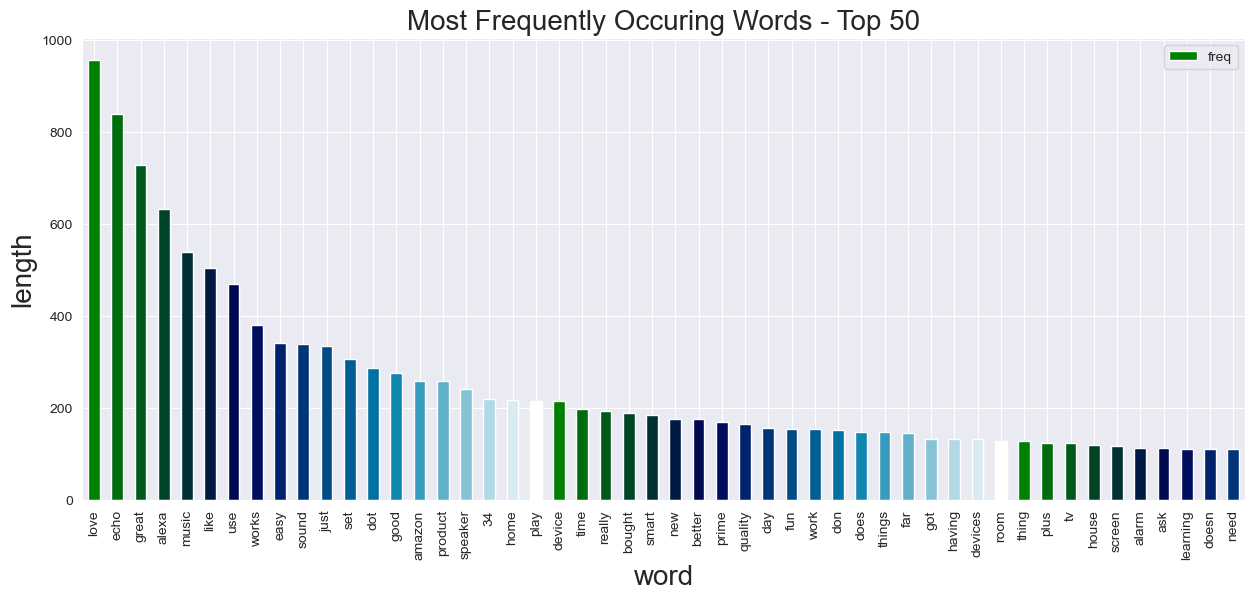

In [47]:
''' barplot of top 50 frequently occuring words '''
color = plt.cm.ocean(np.linspace(0, 1, 20))
freq.head(50).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Occuring Words - Top 50", fontsize=20)
plt.xlabel('word', fontsize=20)
plt.ylabel('length', fontsize=20);

In [48]:
pip install wordcloud


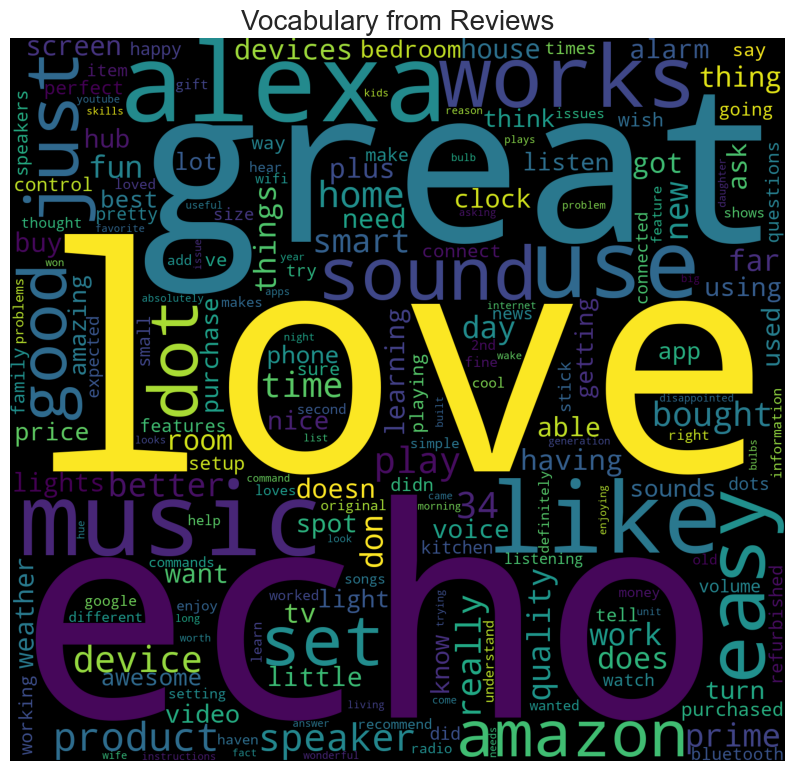

In [49]:
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming you have already calculated w_f as a list of tuples containing words and their frequencies

# Generate word cloud from word-frequency dictionary
word_cloud = WordCloud(background_color='black', width=1500, height=1400).generate_from_frequencies(dict(w_f))

# Plotting the word cloud
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(word_cloud)
plt.title("Vocabulary from Reviews", fontsize=20)
plt.show()


In [67]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

# Download NLTK stopwords corpus
nltk.download('stopwords')

c = []

for i in range(0, 3150):
    try:
        ''' removing characters except a-z and A-Z'''
        r = re.sub('[^a-zA-Z]', ' ', df['verified_reviews'][i])

        ''' converting every word into lower word'''
        r = r.lower()

        ''' splitting text '''
        r = r.split()

        ''' applying Stemming '''
        ps = PorterStemmer()

        ''' removing stopwords '''
        sw = stopwords.words('english')
        sw.remove('not')

        r = [ps.stem(word) for word in r if not word in set(sw)]

        r = ' '.join(r)

        c.append(r)
    except KeyError:
        # Skip this iteration if KeyError occurs
        pass


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anusha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
''' count vectorizer '''
count_vector = CountVectorizer(max_features=2500) 

''' independent and dependent variables '''
X = count_vector.fit_transform(c).toarray()
y = df.iloc[:, 4].values

''' checking shape '''
print(X.shape)
print(y.shape)

(3149, 2500)
(3149,)


In [69]:
''' train test split '''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [70]:
print("shape of X_train: ", X_train.shape)
print("shape of X_test: ", X_test.shape)

shape of X_train:  (2361, 2500)
shape of X_test:  (788, 2500)


In [71]:
from sklearn.preprocessing import MinMaxScaler

min_max_sc = MinMaxScaler()

X_train = min_max_sc.fit_transform(X_train)

X_test = min_max_sc.transform(X_test)


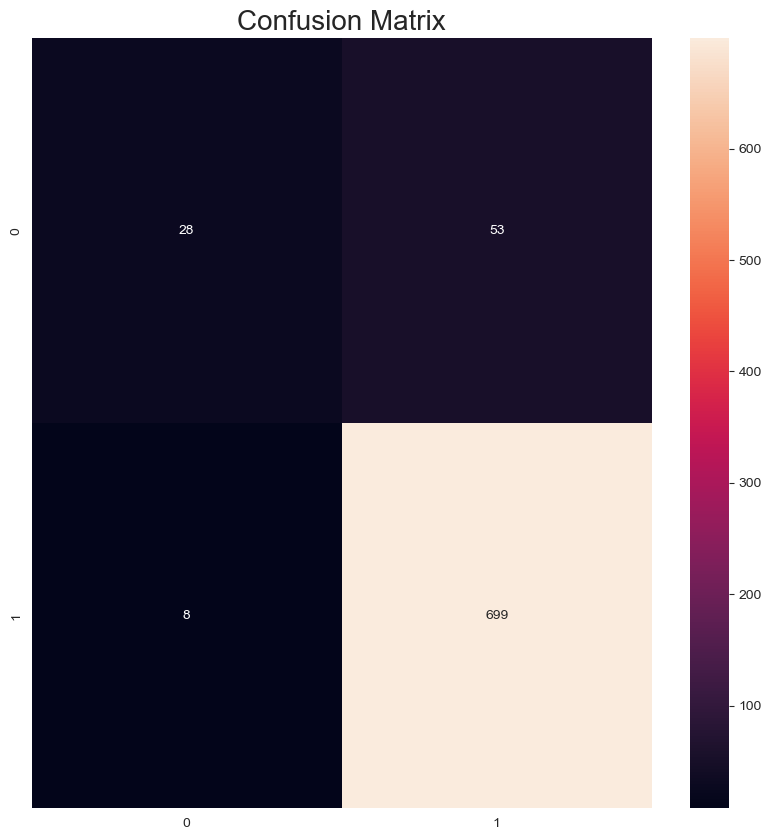

In [72]:
''' Random Forest Classifier '''
rf = RandomForestClassifier()

rf.fit(X_train, y_train)
    
''' prediction ''' 
y_pred = rf.predict(X_test)

''' confusion matrix '''
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g');
plt.title('Confusion Matrix', fontsize=20);

In [75]:
''' Hyperparameter Tunning '''
p = { 
     'bootstrap': [True],
     'max_depth': [80, 100],
     'min_samples_split': [8,12],
     'n_estimators': [100, 300]
}

''' grid search CV '''
grid_cv = GridSearchCV(estimator=rf, param_grid=p, cv=10, verbose=0, scoring='accuracy', n_jobs=-1,
                       return_train_score=True)
grid_cv.fit(X_train, y_train.ravel())

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True, scoring='accuracy')

In [86]:
print("Best Parameter : {}".format(grid_cv.best_params_))

Best Parameter : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 12, 'n_estimators': 100}


In [87]:
rf_cv = RandomForestClassifier(bootstrap=True, max_depth=80, min_samples_split=8, n_estimators=300)

''' fit on data '''
rf_cv.fit(X_train, y_train)

''' prediction '''
pred = rf_cv.predict(X_test)

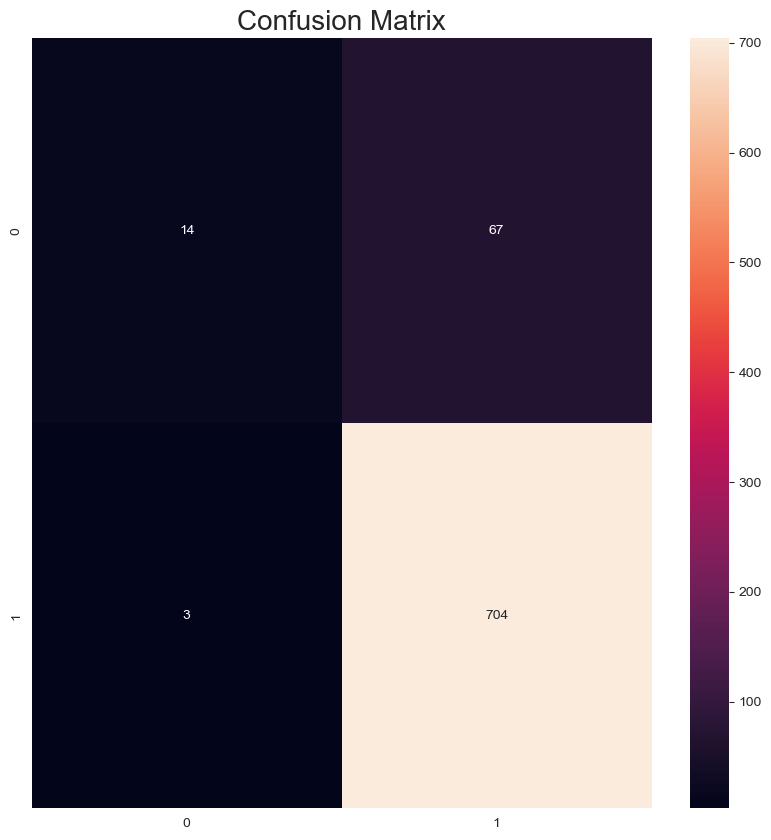

In [88]:
''' confusion matrix '''
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='g');
plt.title('Confusion Matrix', fontsize=20);